# Transpiling Circuits and Obtaining Interaction Graphs

Here we implement code using ChatGPT to obtain (unweighted) interaction graphs based on using the Qiskit transpiler. This can be compared to the uncompiled circuits' interaction graphs. This can also be used to design Hardware ASICs for specific algorithms. This is a partial implementation of the paper [Interaction graph-based characterization of quantum benchmarks for improving quantum circuit mapping techniques](https://arxiv.org/abs/2212.06640).

In [1]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.providers.aer import QasmSimulator

def transpile_circuit(circuit, basis_gates):
    # Define the target basis set
    transpile_config = {
        'basis_gates': basis_gates
    }

    # Transpile the circuit
    transpiled_circuit = transpile(circuit, **transpile_config)

    return transpiled_circuit

# Define your circuit
qubits = 3
circuit = QuantumCircuit(qubits)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.measure_all()

# Define the target basis set
target_set = ['u3', 'cx']

# Transpile the circuit
transpiled_circuit = transpile_circuit(circuit, target_set)

# Print the transpiled circuit
print(transpiled_circuit)


        ┌─────────────┐           ░ ┌─┐      
   q_0: ┤ U3(π/2,0,π) ├──■────────░─┤M├──────
        └─────────────┘┌─┴─┐      ░ └╥┘┌─┐   
   q_1: ───────────────┤ X ├──■───░──╫─┤M├───
                       └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ────────────────────┤ X ├─░──╫──╫─┤M├
                            └───┘ ░  ║  ║ └╥┘
meas: 3/═════════════════════════════╩══╩══╩═
                                     0  1  2 


In [2]:
import networkx as nx
from qiskit import QuantumCircuit
from qiskit.compiler import transpile

def transpile_circuit(circuit, basis_gates):
    # Define the target basis set
    transpile_config = {
        'basis_gates': basis_gates
    }

    # Transpile the circuit
    transpiled_circuit = transpile(circuit, **transpile_config)

    return transpiled_circuit

def circuit_to_graph(circuit, target_set):
    # Transpile the circuit into the target set
    transpiled_circuit = transpile_circuit(circuit, target_set)

    # Initialize an empty graph
    graph = nx.Graph()

    # Add a node for each qubit
    for qubit in transpiled_circuit.qubits:
        graph.add_node(str(qubit))

    # Add an edge for each two-qubit gate
    for gate in transpiled_circuit:
        if len(gate.qubits) == 2:
            q1, q2 = gate.qubits
            graph.add_edge(str(q1), str(q2))

    return graph


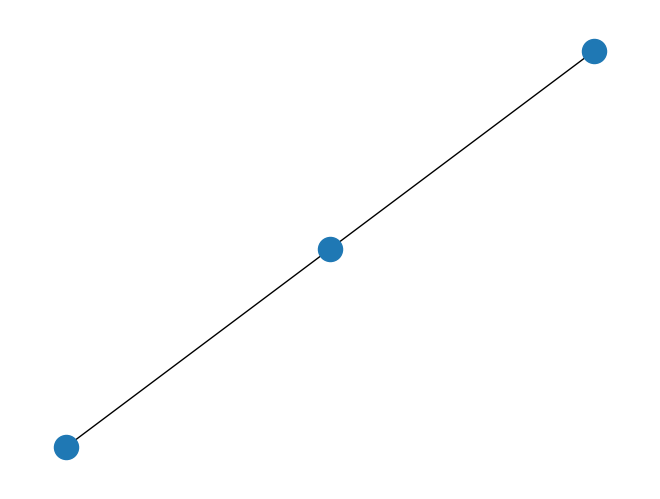

In [3]:
# Define your circuit
qubits = 3
circuit = QuantumCircuit(qubits)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.measure_all()

# Define the target gate set
target_set = ['u3', 'cx']

# Convert the circuit to a graph
graph = circuit_to_graph(circuit, target_set)

# Print the graph
nx.draw(graph)


In [4]:
import networkx as nx
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.random import random_unitary

def graph_state_circuit(num_qubits):
    """Returns a graph state circuit on num_qubits qubits"""
    # Generate a random graph with num_qubits nodes
    graph = nx.fast_gnp_random_graph(num_qubits, 0.5)

    # Initialize the circuit with the given qubits
    qubits = QuantumRegister(num_qubits)
    circuit = QuantumCircuit(qubits)

    # Apply Hadamard gates to all qubits
    circuit.h(qubits)

    # Apply random controlled unitary gates to each edge
    for edge in graph.edges():
        control_qubit, target_qubit = qubits[edge[0]], qubits[edge[1]]

        # Generate a random unitary matrix
        random_unitary_matrix = random_unitary(2).data

        # Apply the controlled random unitary gate to the circuit
        controlled_unitary_gate = UnitaryGate(random_unitary_matrix).control()
        circuit.append(controlled_unitary_gate, [control_qubit, target_qubit])

    # Define number of qubits in circuit
    # circuit.num_qubits = len(circuit.qubits)

    return circuit

In [5]:
num_qubits = 4
circuit2 = graph_state_circuit(num_qubits)
circuit2.draw()

┌───┐                                 
q8_0: ┤ H ├─────■──────────■────────────────
      ├───┤┌────┴────┐     │                
q8_1: ┤ H ├┤ Unitary ├─────┼────────────────
      ├───┤└─────────┘┌────┴────┐           
q8_2: ┤ H ├───────────┤ Unitary ├─────■─────
      ├───┤           └─────────┘┌────┴────┐
q8_3: ┤ H ├──────────────────────┤ Unitary ├
      └───┘                      └─────────┘

In [6]:
target_set = ['u3', 'cx']
circuit_2 = transpile_circuit(circuit2, target_set)
circuit_2.draw()

┌───────────────────┐┌───┐┌───────────────────────────┐┌───┐»
q8_0: ┤ U3(π/2,1.6961,-π) ├┤ X ├┤ U3(0,0,-1.12988718142083) ├┤ X ├»
      └──┬─────────────┬──┘└─┬─┘└───────────────────────────┘└─┬─┘»
q8_1: ───┤ U3(π/2,0,π) ├─────■─────────────────────────────────■──»
         ├─────────────┤                                          »
q8_2: ───┤ U3(π/2,0,π) ├──────────────────────────────────────────»
         ├─────────────┤                                          »
q8_3: ───┤ U3(π/2,0,π) ├──────────────────────────────────────────»
         └─────────────┘                                          »
«            ┌────────────────┐     ┌───┐   ┌───────────────────┐         »
«q8_0: ──────┤ U3(π/2,0,3π/2) ├─────┤ X ├───┤ U3(π/2,2.0418,-π) ├──────■──»
«      ┌─────┴────────────────┴────┐└─┬─┘┌──┴───────────────────┴───┐┌─┴─┐»
«q8_1: ┤ U3(0,0,-1.11061355943785) ├──■──┤ U3(1.6982,1.2088,4.8005) ├┤ X ├»
«      └───────────────────────────┘     └──────────────────────────┘└───┘»
«q8_2: ───────────────────────────────────────────────────────────────────»
«                                                                         »
«q8_3: ───────────────────────────────────────────────────────────────────»
«                                                                         »
«            ┌────────────────┐      ┌───┐┌───────────────────┐┌───┐»
«q8_0: ──────┤ U3(π/2,0,3π/2) ├──────┤ X ├┤ U3(π/2,2.6216,-π) ├┤ X ├»
«      ┌─────┴────────────────┴─────┐└─┬─┘└───────────────────┘└─┬─┘»
«q8_1: ┤ U3(1.6982,0.58164,-4.3504) ├──■─────────────────────────┼──»
«      └────────────────────────────┘                            │  »
«q8_2: ──────────────────────────────────────────────────────────■──»
«                                                                   »
«q8_3: ─────────────────────────────────────────────────────────────»
«                                                                   »
«      ┌───────────────────────────┐┌───┐      ┌────────────────┐     ┌───┐»
«q8_0: ┤ U3(0,0,0.641843539942735) ├┤ X ├──────┤ U3(π/2,0,3π/2) ├─────┤ X ├»
«      └───────────────────────────┘└─┬─┘      └────────────────┘     └─┬─┘»
«q8_1: ───────────────────────────────┼─────────────────────────────────┼──»
«                                     │  ┌───────────────────────────┐  │  »
«q8_2: ───────────────────────────────■──┤ U3(0,0,0.144534941678085) ├──■──»
«                                        └───────────────────────────┘     »
«q8_3: ────────────────────────────────────────────────────────────────────»
«                                                                          »
«         ┌───────────────────┐               ┌────────────────┐     ┌───┐»
«q8_0: ───┤ U3(π/2,-2.6475,π) ├──────■────────┤ U3(π/2,0,3π/2) ├─────┤ X ├»
«         └───────────────────┘      │        └────────────────┘     └─┬─┘»
«q8_1: ──────────────────────────────┼─────────────────────────────────┼──»
«      ┌──────────────────────────┐┌─┴─┐┌───────────────────────────┐  │  »
«q8_2: ┤ U3(1.6576,1.0179,4.7608) ├┤ X ├┤ U3(1.6576,-2.4056,2.1237) ├──■──»
«      └──────────────────────────┘└───┘└───────────────────────────┘     »
«q8_3: ───────────────────────────────────────────────────────────────────»
«                                                                         »
«          ┌───────────────────┐                                            »
«q8_0: ────┤ U3(π/2,1.3671,-π) ├────────────────────────────────────────────»
«          └───────────────────┘                                            »
«q8_1: ─────────────────────────────────────────────────────────────────────»
«      ┌───────────────────────────┐┌───┐┌────────────────────────────┐┌───┐»
«q8_2: ┤ U3(0,0,-1.06786788837551) ├┤ X ├┤ U3(0,0,-0.420116196782899) ├┤ X ├»
«      └───────────────────────────┘└─┬─┘└────────────────────────────┘└─┬─┘»
«q8_3: ───────────────────────────────■──────────────────────────────────■──»
«                                                                           »
«

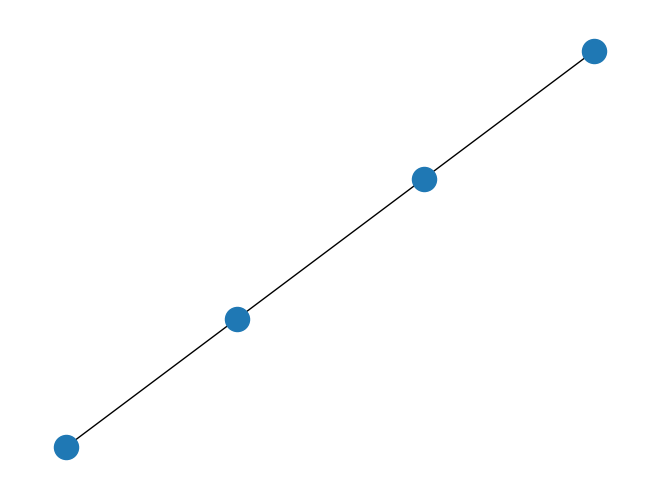

In [7]:
# Define the target gate set
target_set = ['u3', 'cx']

# Convert the circuit to a graph
graph = circuit_to_graph(circuit2, target_set)

# Print the graph
nx.draw(graph)

Now, to add in edge weights corresponding to two-qubit gate counts for each pair of interacting qubits, we can modify our code as follows. 

In [8]:
import networkx as nx
from qiskit.compiler import transpile

def circuit_to_graph(circuit, target_set):
    # Transpile the circuit into the target set
    transpiled_circuit = transpile(circuit, basis_gates=target_set)

    # Initialize an empty graph
    graph = nx.Graph()

    # Add a node for each qubit
    for qubit in transpiled_circuit.qubits:
        graph.add_node(str(qubit))

    # Add an edge for each two-qubit gate, with weight equal to number of times the gate is applied
    for gate in transpiled_circuit:
        if len(gate.qubits) == 2:
            q1, q2 = gate.qubits
            edge_weight = graph.get_edge_data(str(q1), str(q2), default={"weight": 0})["weight"]
            graph.add_edge(str(q1), str(q2), weight=edge_weight + 1)

    return graph


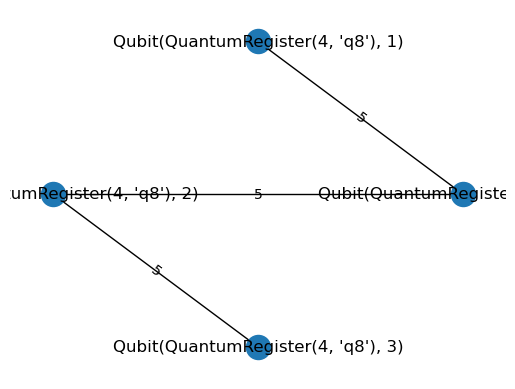

In [10]:
from matplotlib import pyplot as plt

# Define the target basis set
target_set = ['u3', 'cx']

# Get the graph from the circuit
graph = circuit_to_graph(circuit2, target_set)

# Plot the graph with edge weights labeled
pos = nx.circular_layout(graph)
edge_labels = {(u, v): d['weight'] for u, v, d in graph.edges(data=True)}
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
nx.draw(graph, pos, with_labels=True)
plt.show()

Note, edge weights may be limited by your maximum gate count used in approximating gates with the specified basis gate set (in our case `['u3', 'cx']`.

In [11]:
graph.edges

EdgeView([("Qubit(QuantumRegister(4, 'q8'), 0)", "Qubit(QuantumRegister(4, 'q8'), 1)"), ("Qubit(QuantumRegister(4, 'q8'), 0)", "Qubit(QuantumRegister(4, 'q8'), 2)"), ("Qubit(QuantumRegister(4, 'q8'), 2)", "Qubit(QuantumRegister(4, 'q8'), 3)")])

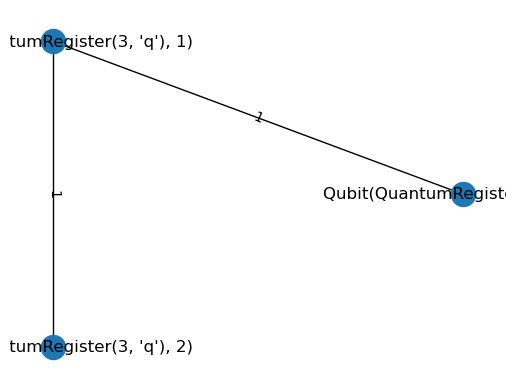

In [12]:
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt

# Define your circuit
qubits = 3
circuit = QuantumCircuit(qubits)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.measure_all()

# Define the target basis set
target_set = ['u3', 'cx']

# Get the graph from the circuit
graph = circuit_to_graph(circuit, target_set)

# Plot the graph with edge weights labeled
pos = nx.circular_layout(graph)
edge_labels = {(u, v): d['weight'] for u, v, d in graph.edges(data=True)}
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
nx.draw(graph, pos, with_labels=True)
plt.show()


## Persistent Homology of Weighted Interaction Graphs

We can now apply methods found in the [persistent_homology_graphs.ipynb](https://github.com/giotto-ai/giotto-tda/blob/master/examples/persistent_homology_graphs.ipynb) using persistent homology to study weighted graphs. 